In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
#plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
train = pd.read_csv("C:/Users/Eugene/Desktop/Output/Numbers/train.csv")
test = pd.read_csv("C:/Users/Eugene/Desktop/Output/Numbers/test.csv")
print(train.shape, test.shape)

(42000, 785) (28000, 784)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

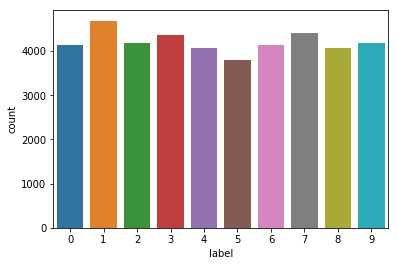

In [5]:
train_types_values = train["label"]

# Drop 'label' column
number_images = train.drop(labels = ["label"],axis = 1)
#del train 

g = sns.countplot(train_types_values)
train_types_values.value_counts()

In [6]:
#Data preparation
number_images = (number_images/255).values.reshape(-1,28,28,1)
test=(test/255).values.reshape(-1,28,28,1)
train_types = to_categorical(train_types_values, num_classes = 10)

In [7]:
#Split data for cross-validation of NN parameters
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9)
print(sss.get_n_splits(number_images, train_types_values))
for train_index, test_index in sss.split(number_images, train_types_values):
    images_test, images_train = number_images[train_index], number_images[test_index]
    answers_test, answers_train = train_types[train_index], train_types[test_index]



1


In [8]:
images_train.shape[0]

37800

In [9]:
# The NN layot
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=1e-3, rho=0.9, epsilon=1e-8, decay=0.0)
#optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", 
              metrics=["accuracy"])

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, 
                                            verbose=1, factor=0.5, min_lr=1e-6)
epochs = 1 
batch_size = 86
for train_index, test_index in sss.split(number_images, train_types_values):
    images_test, images_train = number_images[train_index], number_images[test_index]
    answers_test, answers_train = train_types[train_index], train_types[test_index]
#    history = model.fit(images_train, answers_train, batch_size = batch_size, epochs = epochs, 
#             validation_data = (images_test, answers_test), verbose = 2)

In [ ]:
epochs = 10 
batch_size = 100
history = model.fit(images_train, answers_train, batch_size = batch_size, epochs = epochs, 
         validation_data = (images_test, answers_test), verbose = 2, callbacks=[learning_rate_reduction])


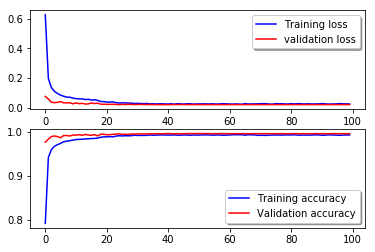

In [36]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(images_train)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, 
                                            verbose=1, factor=0.5, min_lr=1e-8)
epochs = 50
batch_size = 189
steps=images_train.shape[0]
print(steps)
# Fit the model
history = model.fit_generator(datagen.flow(images_train,answers_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (images_test,answers_test),
                              verbose = 2, steps_per_epoch=images_train.shape[0]// batch_size
                               , callbacks=[learning_rate_reduction])



37800
Epoch 1/50
 - 368s - loss: 0.3978 - acc: 0.8770 - val_loss: 0.2336 - val_acc: 0.9390
Epoch 2/50
 - 403s - loss: 0.1236 - acc: 0.9610 - val_loss: 0.0462 - val_acc: 0.9852
Epoch 3/50
 - 411s - loss: 0.0889 - acc: 0.9722 - val_loss: 0.0829 - val_acc: 0.9793
Epoch 4/50
 - 370s - loss: 0.0762 - acc: 0.9765 - val_loss: 0.0705 - val_acc: 0.9779
Epoch 5/50
 - 386s - loss: 0.0668 - acc: 0.9804 - val_loss: 0.0344 - val_acc: 0.9888
Epoch 6/50
 - 411s - loss: 0.0593 - acc: 0.9820 - val_loss: 0.0352 - val_acc: 0.9893
Epoch 7/50
 - 404s - loss: 0.0569 - acc: 0.9829 - val_loss: 0.0341 - val_acc: 0.9905
Epoch 8/50
 - 401s - loss: 0.0525 - acc: 0.9835 - val_loss: 0.0292 - val_acc: 0.9912
Epoch 9/50
 - 412s - loss: 0.0464 - acc: 0.9862 - val_loss: 0.0256 - val_acc: 0.9926
Epoch 10/50
 - 402s - loss: 0.0472 - acc: 0.9850 - val_loss: 0.0589 - val_acc: 0.9829
Epoch 11/50
 - 391s - loss: 0.0440 - acc: 0.9866 - val_loss: 0.0281 - val_acc: 0.9924
Epoch 12/50
 - 301s - loss: 0.0429 - acc: 0.9872 - val_lo

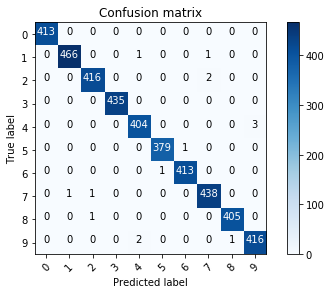

In [13]:
# Predict the values from the validation dataset
answers_prediction = model.predict(images_test)
# Convert predictions classes to one hot vectors 
answers_pred_classes = np.argmax(answers_prediction, axis = 1) 
# Convert validation observations to one hot vectors
answers_true = np.argmax(answers_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(answers_true, answers_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

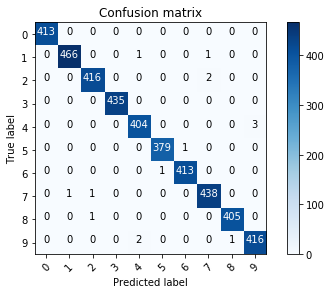

In [14]:
# Predict the values from the validation dataset
answers_prediction = model.predict(images_test)
# Convert predictions classes to one hot vectors 
answers_pred_classes = np.argmax(answers_prediction, axis = 1) 
# Convert validation observations to one hot vectors
answers_true = np.argmax(answers_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(answers_true, answers_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [15]:
# predict results

results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("numbers_output.csv",index=False)



In [16]:
#Saving a particularly sucessfull model I like:
model.save('Num_recognition_99614.h5')